In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import numpy as np
from scipy.stats import iqr
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
# training parameters
epochs = 100
batch_size = 8
loss = tf.keras.losses.MeanAbsoluteError()
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.90)
input_path = '../../data/'
output_path = './model/'


In [3]:
# load data
x_train = pickle.load(open(input_path+'/x_train.pkl', 'rb'))
y_train = pickle.load(open(input_path+'/y_train.pkl', 'rb'))
sizes_train = pickle.load(open(input_path+'/sizes_train.pkl', 'rb'))
x_val = pickle.load(open(input_path+'/x_test.pkl', 'rb'))
y_val = pickle.load(open(input_path+'/y_test.pkl', 'rb'))
sizes_val = pickle.load(open(input_path+'/sizes_test.pkl', 'rb'))


In [4]:
# standardize
x_train = [np.array(i) for i in x_train]
x_val = [np.array(i) for i in x_val]

y_train = [(i-j.mean())/j.std() for i,j in zip(y_train, x_train)]
y_val = [(i-j.mean())/j.std() for i,j in zip(y_val, x_val)]
x_train = [(i-i.mean())/i.std() for i in x_train]
x_val = [(i-i.mean())/i.std() for i in x_val]


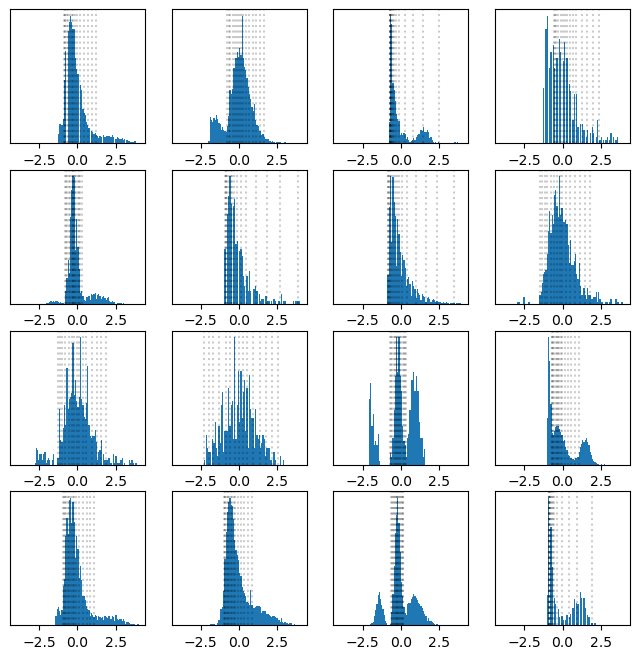

In [5]:
# plot example data points
nr = 4
nc = 4
plt.figure(figsize=(8,8))
idx = np.random.choice(len(x_train), nr*nc)
bins = np.linspace(-4, 4, 101)
for i in range(nr*nc):
    plt.subplot(nr, nc, i+1)
    plt.hist(x_train[idx[i]], bins, density=True)
    for j in range(len(y_train[0])):
        plt.axvline(y_train[idx[i]][j], c='k', linestyle=':', alpha=0.2)
    plt.yticks([])
    

In [6]:
# optionally add size prediction

y_train = np.array(y_train)
y_train = np.hstack([
    y_train, 
    np.array([i[0]/sum(i) for i in sizes_train]).reshape(-1, 1)
])

y_val = np.array(y_val)
y_val = np.hstack([
    y_val, 
    np.array([i[0]/sum(i) for i in sizes_val]).reshape(-1, 1)
])


In [7]:
def extract_features(data):

    features = np.histogram(data, np.linspace(-4, 4, 101), density=True)[0]
    features = (features - features.min())/(features.max() - features.min())
    
    return features.reshape(-1, 1)


In [8]:
# extract features
x_train = [extract_features(i) for i in x_train]
x_train = np.array(x_train)
x_val = [extract_features(i) for i in x_val]
x_val = np.array(x_val)


In [9]:
x_train.shape

(5000, 100, 1)

In [10]:
y_train.shape


(5000, 16)

In [11]:
# standardize

scalery = RobustScaler()
y_train = scalery.fit_transform(y_train)
y_val = scalery.transform(y_val)


In [12]:
# define model

inputs = tf.keras.layers.Input(shape=x_train.shape[1:])
x = tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu')(inputs)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
o = tf.keras.layers.Dense(y_val.shape[1], activation='linear')(x)
model = tf.keras.models.Model(inputs, o)

# define loss and optimizer
model.compile(loss = loss,
              optimizer = opt)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 98, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 64)            12352 

In [13]:
# define best model checkpoint
checkpoint_path = output_path+'/model_checkpoint'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_format='tf',
    verbose=1
)

# train
history = model.fit(
    x_train, 
    y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [checkpoint_callback],
    verbose = 2
)

with open(output_path+'/model_history.npy', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)



Epoch 1/100


I0000 00:00:1716797852.134023   13279 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.30662, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 5s - loss: 0.4282 - val_loss: 0.3066 - 5s/epoch - 8ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.30662 to 0.26278, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.2911 - val_loss: 0.2628 - 3s/epoch - 4ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.26278 to 0.23295, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 2s - loss: 0.2582 - val_loss: 0.2329 - 2s/epoch - 4ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.23295 to 0.23050, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 2s - loss: 0.2393 - val_loss: 0.2305 - 2s/epoch - 4ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.23050 to 0.21449, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 2s - loss: 0.2228 - val_loss: 0.2145 - 2s/epoch - 4ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 0.21449
625/625 - 2s - loss: 0.2118 - val_loss: 0.2271 - 2s/epoch - 3ms/step
Epoch 7/100

Epoch 7: val_loss improved from 0.21449 to 0.20336, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.2033 - val_loss: 0.2034 - 3s/epoch - 5ms/step
Epoch 8/100

Epoch 8: val_loss did not improve from 0.20336
625/625 - 2s - loss: 0.1922 - val_loss: 0.2052 - 2s/epoch - 4ms/step
Epoch 9/100

Epoch 9: val_loss improved from 0.20336 to 0.18805, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.1882 - val_loss: 0.1881 - 3s/epoch - 5ms/step
Epoch 10/100

Epoch 10: val_loss improved from 0.18805 to 0.17834, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.1823 - val_loss: 0.1783 - 3s/epoch - 4ms/step
Epoch 11/100

Epoch 11: val_loss did not improve from 0.17834
625/625 - 2s - loss: 0.1796 - val_loss: 0.1909 - 2s/epoch - 4ms/step
Epoch 12/100

Epoch 12: val_loss improved from 0.17834 to 0.17393, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.1749 - val_loss: 0.1739 - 3s/epoch - 6ms/step
Epoch 13/100

Epoch 13: val_loss did not improve from 0.17393
625/625 - 3s - loss: 0.1710 - val_loss: 0.1820 - 3s/epoch - 4ms/step
Epoch 14/100

Epoch 14: val_loss improved from 0.17393 to 0.17066, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.1676 - val_loss: 0.1707 - 3s/epoch - 5ms/step
Epoch 15/100

Epoch 15: val_loss improved from 0.17066 to 0.16375, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.1650 - val_loss: 0.1637 - 3s/epoch - 5ms/step
Epoch 16/100

Epoch 16: val_loss did not improve from 0.16375
625/625 - 3s - loss: 0.1616 - val_loss: 0.1754 - 3s/epoch - 4ms/step
Epoch 17/100

Epoch 17: val_loss did not improve from 0.16375
625/625 - 3s - loss: 0.1584 - val_loss: 0.1831 - 3s/epoch - 4ms/step
Epoch 18/100

Epoch 18: val_loss did not improve from 0.16375
625/625 - 3s - loss: 0.1578 - val_loss: 0.1656 - 3s/epoch - 4ms/step
Epoch 19/100

Epoch 19: val_loss improved from 0.16375 to 0.15676, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.1530 - val_loss: 0.1568 - 3s/epoch - 5ms/step
Epoch 20/100

Epoch 20: val_loss did not improve from 0.15676
625/625 - 3s - loss: 0.1519 - val_loss: 0.1641 - 3s/epoch - 4ms/step
Epoch 21/100

Epoch 21: val_loss did not improve from 0.15676
625/625 - 3s - loss: 0.1505 - val_loss: 0.1580 - 3s/epoch - 5ms/step
Epoch 22/100

Epoch 22: val_loss improved from 0.15676 to 0.15142, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.1479 - val_loss: 0.1514 - 3s/epoch - 5ms/step
Epoch 23/100

Epoch 23: val_loss did not improve from 0.15142
625/625 - 3s - loss: 0.1455 - val_loss: 0.1744 - 3s/epoch - 4ms/step
Epoch 24/100

Epoch 24: val_loss did not improve from 0.15142
625/625 - 3s - loss: 0.1432 - val_loss: 0.1586 - 3s/epoch - 4ms/step
Epoch 25/100

Epoch 25: val_loss did not improve from 0.15142
625/625 - 3s - loss: 0.1432 - val_loss: 0.1529 - 3s/epoch - 4ms/step
Epoch 26/100

Epoch 26: val_loss did not improve from 0.15142
625/625 - 3s - loss: 0.1403 - val_loss: 0.1592 - 3s/epoch - 4ms/step
Epoch 27/100

Epoch 27: val_loss did not improve from 0.15142
625/625 - 3s - loss: 0.1400 - val_loss: 0.1523 - 3s/epoch - 4ms/step
Epoch 28/100

Epoch 28: val_loss improved from 0.15142 to 0.15028, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.1387 - val_loss: 0.1503 - 3s/epoch - 5ms/step
Epoch 29/100

Epoch 29: val_loss improved from 0.15028 to 0.14628, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.1356 - val_loss: 0.1463 - 3s/epoch - 5ms/step
Epoch 30/100

Epoch 30: val_loss did not improve from 0.14628
625/625 - 2s - loss: 0.1348 - val_loss: 0.1518 - 2s/epoch - 4ms/step
Epoch 31/100

Epoch 31: val_loss did not improve from 0.14628
625/625 - 3s - loss: 0.1336 - val_loss: 0.1531 - 3s/epoch - 4ms/step
Epoch 32/100

Epoch 32: val_loss improved from 0.14628 to 0.14286, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1315 - val_loss: 0.1429 - 4s/epoch - 6ms/step
Epoch 33/100

Epoch 33: val_loss did not improve from 0.14286
625/625 - 3s - loss: 0.1312 - val_loss: 0.1459 - 3s/epoch - 4ms/step
Epoch 34/100

Epoch 34: val_loss did not improve from 0.14286
625/625 - 3s - loss: 0.1302 - val_loss: 0.1508 - 3s/epoch - 4ms/step
Epoch 35/100

Epoch 35: val_loss did not improve from 0.14286
625/625 - 3s - loss: 0.1290 - val_loss: 0.1472 - 3s/epoch - 4ms/step
Epoch 36/100

Epoch 36: val_loss did not improve from 0.14286
625/625 - 3s - loss: 0.1278 - val_loss: 0.1462 - 3s/epoch - 4ms/step
Epoch 37/100

Epoch 37: val_loss did not improve from 0.14286
625/625 - 3s - loss: 0.1260 - val_loss: 0.1519 - 3s/epoch - 4ms/step
Epoch 38/100

Epoch 38: val_loss did not improve from 0.14286
625/625 - 3s - loss: 0.1246 - val_loss: 0.1571 - 3s/epoch - 4ms/step
Epoch 39/100

Epoch 39: val_loss did not improve from 0.14286
625/625 - 2s - loss: 0.1242 - val_loss: 0.1540 - 2s/epoch - 4ms/step
Epoch 40/100



INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.1180 - val_loss: 0.1428 - 3s/epoch - 5ms/step
Epoch 48/100

Epoch 48: val_loss did not improve from 0.14280
625/625 - 3s - loss: 0.1144 - val_loss: 0.1445 - 3s/epoch - 4ms/step
Epoch 49/100

Epoch 49: val_loss improved from 0.14280 to 0.13989, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.1156 - val_loss: 0.1399 - 3s/epoch - 5ms/step
Epoch 50/100

Epoch 50: val_loss did not improve from 0.13989
625/625 - 3s - loss: 0.1131 - val_loss: 0.1428 - 3s/epoch - 4ms/step
Epoch 51/100

Epoch 51: val_loss did not improve from 0.13989
625/625 - 3s - loss: 0.1138 - val_loss: 0.1498 - 3s/epoch - 4ms/step
Epoch 52/100

Epoch 52: val_loss did not improve from 0.13989
625/625 - 3s - loss: 0.1135 - val_loss: 0.1476 - 3s/epoch - 4ms/step
Epoch 53/100

Epoch 53: val_loss did not improve from 0.13989
625/625 - 3s - loss: 0.1120 - val_loss: 0.1428 - 3s/epoch - 4ms/step
Epoch 54/100

Epoch 54: val_loss did not improve from 0.13989
625/625 - 3s - loss: 0.1106 - val_loss: 0.1475 - 3s/epoch - 4ms/step
Epoch 55/100

Epoch 55: val_loss did not improve from 0.13989
625/625 - 3s - loss: 0.1117 - val_loss: 0.1450 - 3s/epoch - 4ms/step
Epoch 56/100

Epoch 56: val_loss did not improve from 0.13989
625/625 - 3s - loss: 0.1103 - val_loss: 0.1449 - 3s/epoch - 4ms/step
Epoch 57/100



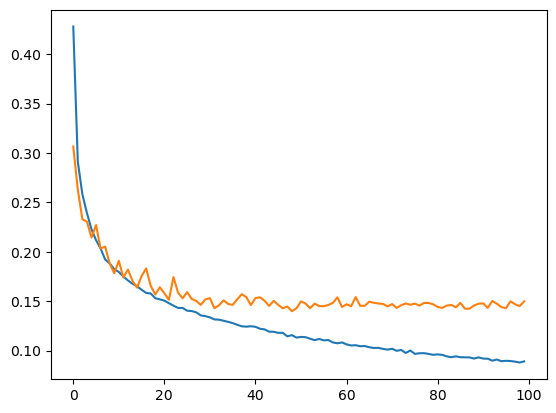

In [14]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);


In [15]:
# save scaler
with open(output_path+'/model_y_scaler.pkl', 'wb') as f:
    pickle.dump(scalery, f)
